In [18]:
import torch
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import warnings
# These warnings are not impactful on the output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*incompatible shapes.*")

In [19]:
# this block is used when changing the registered dataset

from detectron2.data import MetadataCatalog
# remove metadata of dataset from registry
MetadataCatalog.remove("barnacle_train")

In [20]:
# Register dataset
register_coco_instances(
    "barnacle_train",
    {},
    "barnacle_dataset/annotations/train.json",  # COCO-style annotations (see below)
    "barnacle_dataset/train/images"  # Path to image directory
)

In [21]:
# create config
cfg = get_cfg()

# load base from model zoo
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# dataset config
cfg.DATASETS.TRAIN = ("barnacle_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 1

# model config
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only barnacle class

# memory optimization
cfg.MODEL.FPN.OUT_CHANNELS = 192
cfg.TEST.DETECTIONS_PER_IMAGE = 2000
cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = 2500
cfg.MODEL.RPN.POST_NMS_TOPK_TRAIN = 2000
cfg.SOLVER.AMP.ENABLED = True  # Automatic Mixed Precision
torch.cuda.empty_cache()


# Training Configuration
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.00015
cfg.SOLVER.MAX_ITER = 2000
cfg.SOLVER.STEPS = [1000, 1500]
cfg.SOLVER.GAMMA = 0.1

# Warmup Configuration
cfg.SOLVER.WARMUP_FACTOR = 1.0 / 1000
cfg.SOLVER.WARMUP_ITERS = 150
cfg.SOLVER.WARMUP_METHOD = "linear"

# Gradient Clipping
cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True
cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE = 1.0

In [5]:
# Start training
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[01/28 00:24:35 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 192, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 192, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 192, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 192, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'backbone.fpn_lateral2.weight' to the model due to incompatible shapes: (256, 256, 1, 1) in the checkpoint but (192, 256, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'backbone.fpn_lateral2.bias' to the model due to incompatible shapes: (256,) in the checkpoint but (192,) in the model! You might want to double check if this is expected.
Skip loading parameter 'backbone.fpn_output2.weight' to the model due to incompatible shapes: (256, 256, 3, 3) in the checkpoint but (192, 192, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'backbone.fpn_output2.bias' to the model due to incompatible shapes: (256,) in the checkpoint but (192,) in the model! You might want to double check if this is expected.
Skip loading parameter 'backbone.fpn_lateral3.weight' to the model due to incompatible shapes: (256, 512, 1, 1) in the checkpoint but (192, 512, 1, 1) in the model! You might wan

[01/28 00:24:39 d2.engine.train_loop]: Starting training from iteration 0


C:\Users\Aryan Bawa\PyCharmMiscProject\.venv\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/28 00:25:05 d2.utils.events]:  eta: 0:11:59  iter: 19  total_loss: 2.862  loss_cls: 0.6894  loss_box_reg: 0.06061  loss_mask: 0.6926  loss_rpn_cls: 0.6901  loss_rpn_loc: 0.6211    time: 0.9332  last_time: 0.1644  data_time: 0.1747  last_data_time: 0.0044   lr: 3.1885e-05  max_mem: 6413M
[01/28 00:25:25 d2.utils.events]:  eta: 0:09:45  iter: 39  total_loss: 2.812  loss_cls: 0.6685  loss_box_reg: 0.08018  loss_mask: 0.69  loss_rpn_cls: 0.6834  loss_rpn_loc: 0.6838    time: 0.9691  last_time: 0.1982  data_time: 0.0145  last_data_time: 0.0034   lr: 6.5185e-05  max_mem: 6495M
[01/28 00:25:49 d2.utils.events]:  eta: 0:09:54  iter: 59  total_loss: 2.682  loss_cls: 0.6194  loss_box_reg: 0.1191  loss_mask: 0.6847  loss_rpn_cls: 0.6677  loss_rpn_loc: 0.559    time: 1.0554  last_time: 1.1097  data_time: 0.0044  last_data_time: 0.0026   lr: 9.8485e-05  max_mem: 6495M
[01/28 00:26:15 d2.utils.events]:  eta: 0:08:14  iter: 79  total_loss: 2.622  loss_cls: 0.5685  loss_box_reg: 0.1379  loss_mask:

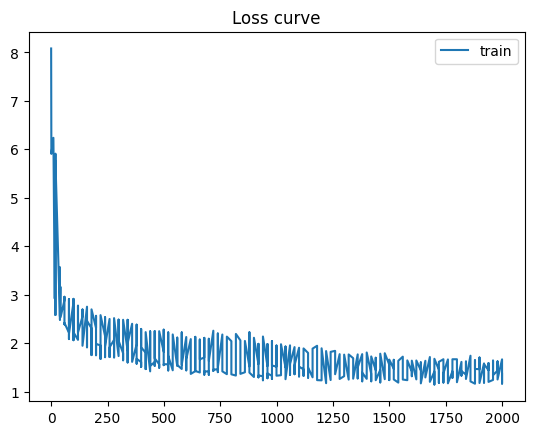

In [23]:
# plot the training loss
metrics_df = pd.read_json("./output/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf.head(10).T
fig, ax = plt.subplots()
mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
# ax.set_ylim([0, 3])
ax.legend()
ax.set_title("Loss curve")

# Save the plot as an image file
# plt.savefig("loss_curve.png")

plt.show()

In [15]:
# Load trained model
cfg.MODEL.WEIGHTS = "output/model_final.pth"
predictor = DefaultPredictor(cfg)

# Predict on a new ROI
roi = cv2.imread("barnacle_dataset/test/roi_unseen_img1.png")
if roi is None:
    raise FileNotFoundError("The image 'barnacle_dataset/test/roi_unseen_img1.png' was not found or could not be read.")

outputs = predictor(roi)

# Visualize results
v = Visualizer(roi[:, :, ::-1], scale=0.5)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2.imshow("Result", out.get_image()[:, :, ::-1])
cv2.waitKey(0)

# Count barnacles
count = len(outputs["instances"])
print(f"Barnacle count: {count}")

[01/28 00:55:42 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/model_final.pth ...
Barnacle count: 263
